# Series de Tiempo

Las secciones del notebook son:
1. Análisis exploratorio de datos:
2. One-Step Prediction: ¿podemos predecir el tráfico por la estación de peajes para el día siguiente?
3. Multi-Step Prediction: ¿podemos predecir el tráfico por la estación de peajes para el 2020?
4. RNN y LSTMs: demostración de su uso.


## 1. Análisis Exploratorio de Datos


Muchas ideas de esta sección fueron tomadas del análisis que figura en [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook) para el dataset [Fremont Bridge Bicycle Counts](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k). Recomiendo fuertemente que, si pueden, lo miren, porque está muy bien explicado.

Arrancamos, como siempre, importando las librerías, el dataset, y haciendo un poco de limpieza.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import datetime

In [8]:
data_2017_19 = pd.read_csv('Data/illia_2017_2019.csv')
data_2017_19.dropna(inplace = True)
data_2017_19.drop(columns = ['Unnamed: 0'], inplace = True)
print(data_2017_19.shape)
data_2017_19.tail()

(238869, 5)


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00
238868,Martes,Provincia,Liviano,190,2019-12-31 23:00:00


In [7]:
data_2017_19.describe()

,cantidad_pasos
count,238869.000000
mean,200.384232
std,403.246904
min,1.000000
25%,2.000000
50%,11.000000
75%,104.000000
max,2416.000000


In [21]:
data_2020_22 = pd.read_csv('Data/illia_2020_2022.csv')
data_2020_22.dropna(inplace = True)
data_2020_22.drop(columns = ['Unnamed: 0'], inplace = True)
data_2020_22['fecha'] = pd.to_datetime(data_2020_22['fecha'], errors='coerce')
print(data_2020_22.shape)
data_2020_22.tail()

(167438, 4)


,fecha,dia,sentido,cantidad_pasos
167433,2022-12-31 19:00:00,Saturday,Centro,9
167434,2022-12-31 19:00:00,Saturday,Provincia,12
167435,2022-12-31 19:00:00,Saturday,Centro,2
167436,2022-12-31 19:00:00,Saturday,Provincia,1
167437,2022-12-31 20:00:00,Saturday,Provincia,1


In [22]:
data_2020_22.describe()

,fecha,cantidad_pasos
count,167438,167438.000000
mean,2021-07-20 23:21:35.426366720,87.460893
min,2020-01-01 00:00:00,1.000000
25%,2020-10-21 10:15:00,2.000000
50%,2021-08-19 20:00:00,10.000000
75%,2022-04-24 21:00:00,60.000000
max,2022-12-31 20:00:00,1458.000000
std,NaN,167.468542


In [23]:
data_2020_22.dtypes

fecha             datetime64[ns]
dia                       object
sentido                   object
cantidad_pasos             int64
dtype: object

**Hacemos un gráfico de los datos**

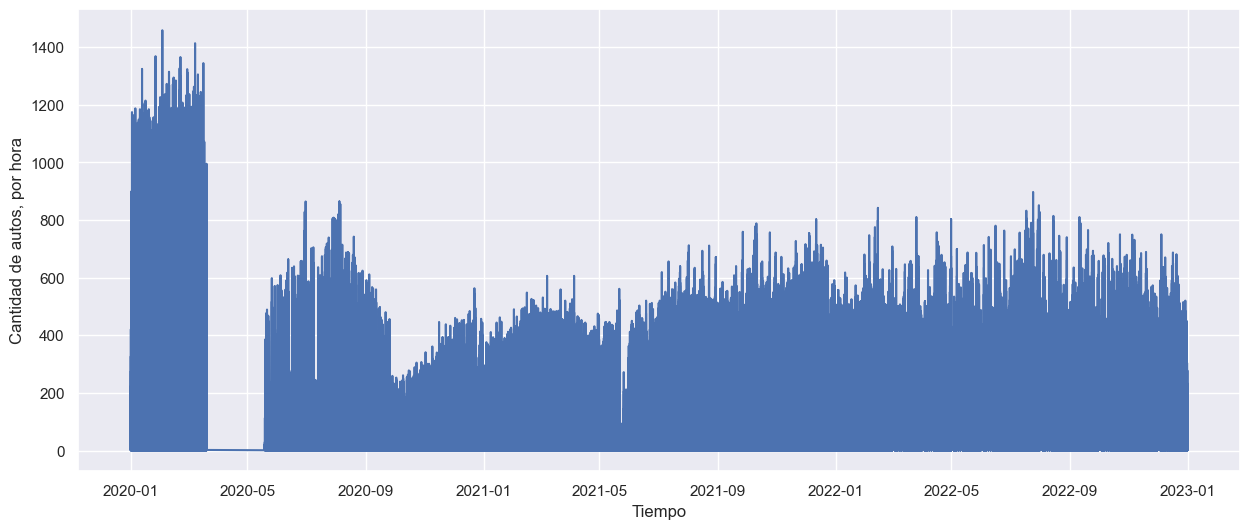

In [24]:
plt.figure(figsize = (15,6))
plt.plot(data_2020_22['fecha'], data_2020_22.cantidad_pasos)
#plt.xlim(datetime.date(2008,2,1), datetime.date(2008,5,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

Pueden observar que la figura es ruidosa y poco clara. ¿A qué se deberá?

Los datos están tomados con una frecuencia horaria. Eso produce una saturación del gráfico. Pandas nos permite *resamplear* el dataset de forma tal de llevar los datos en frecuencia horaria a otra frecuencia. Por ejemplo, diaria.

In [25]:
daily = data_2020_22.resample('D', on = 'fecha').sum()#ojo que me suma todas las columnas, también las string. Eventualmente se podría ver algo con esto, por ahora no lo tenemos en cuenta 
print(daily.shape)
daily.head()

(1096, 3)


,dia,sentido,cantidad_pasos
fecha,,,
2020-01-01,WednesdayWednesdayWednesdayWednesdayWednesdayW...,CentroProvinciaCentroCentroProvinciaProvinciaP...,21395
2020-01-02,ThursdayThursdayThursdayThursdayThursdayThursd...,CentroProvinciaCentroCentroProvinciaProvinciaC...,33722
2020-01-03,FridayFridayFridayFridayFridayFridayFridayFrid...,ProvinciaCentroProvinciaCentroCentroProvinciaC...,37067
2020-01-04,SaturdaySaturdaySaturdaySaturdaySaturdaySaturd...,ProvinciaCentroProvinciaProvinciaProvinciaProv...,30627
2020-01-05,SundaySundaySundaySundaySundaySundaySundaySund...,ProvinciaCentroCentroCentroProvinciaCentroProv...,27812


In [60]:
daily.drop(columns = ['dia','sentido','tipo_vehiculo',], inplace = True)

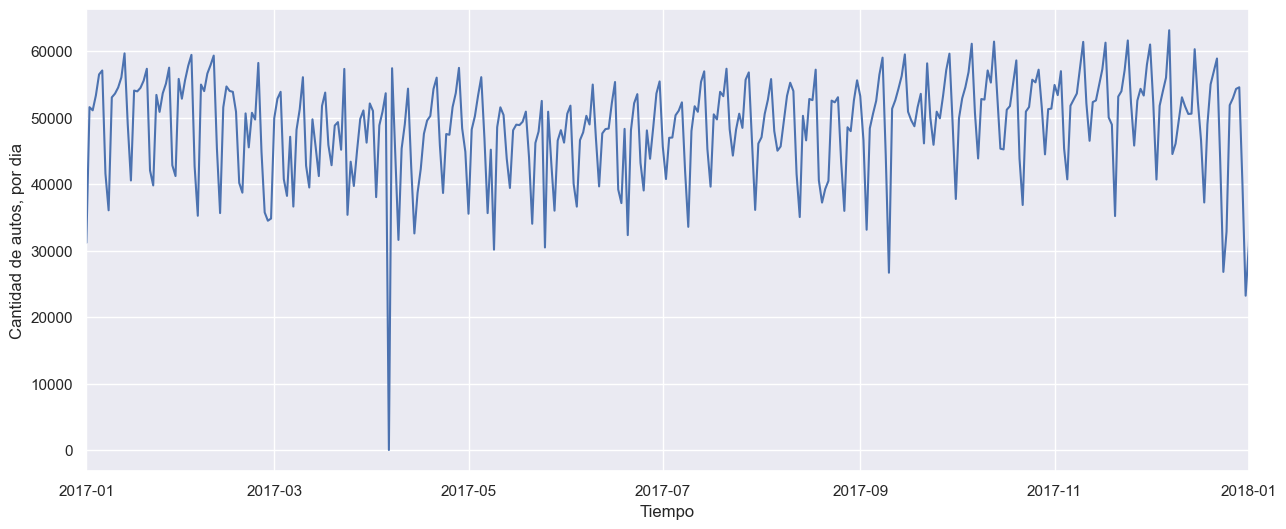

In [61]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim(datetime.date(2017,1,1), datetime.date(2018,1,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Si bien sigue siendo *ruidosa*, ya se empiezan a diferenciar algunas características. ¿Cuáles son? Jugar un poco con los límites del gráfico (`plt.xlim`) y responder: ¿Qué días circulan más autos?¿Qué pasa en las vacaciones de invierno?¿Y para las fiestas de fin de año?

Pasamos los datos a frecuencia semanal

In [62]:
weekly = dataset.resample('W', on = 'ts_end_of_polling').sum()
#Tiramos la ultima semana porque esta muy incompleta
weekly.drop(weekly.tail(1).index, inplace = True)
weekly.drop(columns = ['dia','sentido','tipo_vehiculo',], inplace = True)
print(weekly.shape)
weekly.tail()

(157, 2)


,hora_inicio,cantidad_pasos
ts_end_of_polling,,
2019-12-01,7203,266555
2019-12-08,7726,282891
2019-12-15,7724,272960
2019-12-22,7728,292881
2019-12-29,7551,226390


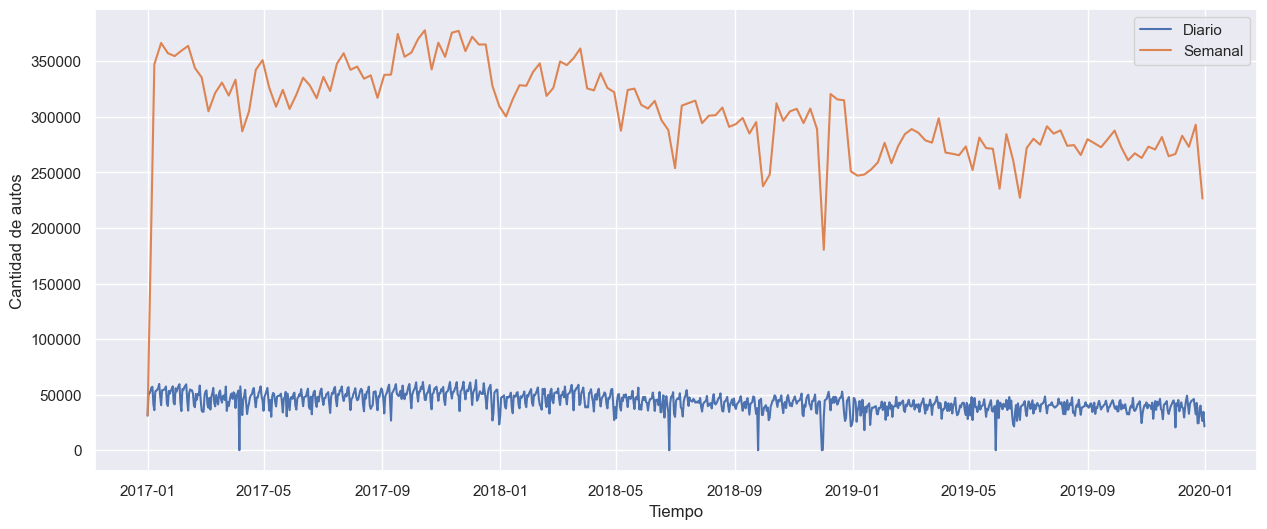

In [63]:
plt.figure(figsize = (15,6))

monthly = dataset.resample('M', on = 'ts_end_of_polling').sum()

# plt.plot(monthly.index, monthly.cantidad_pasos, label='Monthly')

plt.plot(daily.index, daily.cantidad_pasos, label = 'Diario')
plt.plot(weekly.index, weekly.cantidad_pasos, label = 'Semanal')
# plt.xlim(datetime.date(2018,1,1), datetime.date(2019,1,1))
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

**¿Y si agrupamos por horarios?**

Vamos a tomar el promedio en vez de la suma

In [64]:
horario = dataset.copy()
horario.drop(columns = ['dia','sentido','tipo_vehiculo',], inplace = True)
hora = pd.DatetimeIndex(horario['ts_end_of_polling'])
horario

,hora_inicio,cantidad_pasos,ts_end_of_polling
0,23,1,2017-01-01 00:00:00
1,23,9,2017-01-01 00:00:00
2,23,644,2017-01-01 00:00:00
3,23,6,2017-01-01 00:00:00
4,23,1,2017-01-01 00:00:00
...,...,...,...
238864,21,556,2019-12-31 22:00:00
238865,21,1,2019-12-31 22:00:00
238866,21,580,2019-12-31 22:00:00
238867,22,214,2019-12-31 23:00:00


In [83]:
week_of_year = horario.groupby(horario['ts_end_of_polling'].day).mean()

week_of_year

AttributeError: 'Series' object has no attribute 'day'

In [86]:
week = dataset['ts_end_of_polling'].dt.day

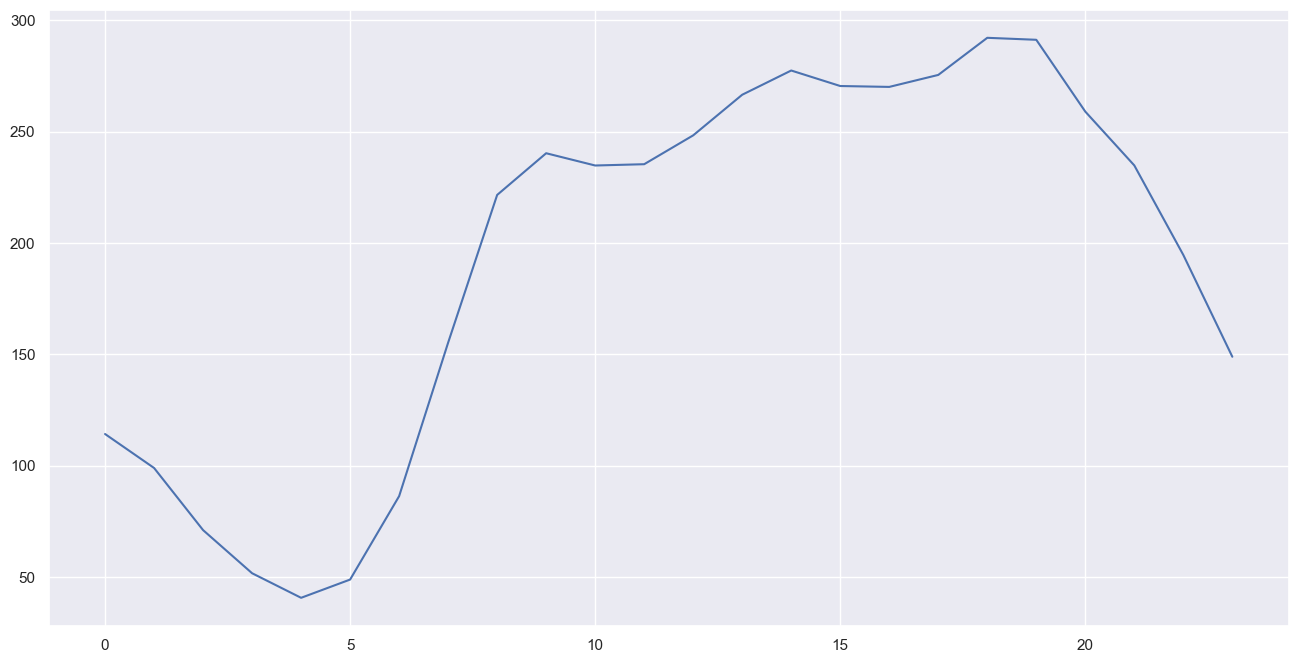

In [ ]:
plt.figure(figsize = (16,8))
plt.plot(agrupado_por_horario.index, agrupado_por_horario.cantidad_pasos)
plt.show()

Interpretar el gráfico que obtuvieron. ¿Se puede hacer mejor?

**Rolling Window**

Googlear que es un "Rolling Window" e interpretar las siguientes celdas. Jugar con los límites

In [69]:
help(pd.Series.rolling)

Help on function rolling in module pandas.core.generic:

rolling(self, window: 'int | dt.timedelta | str | BaseOffset | BaseIndexer', min_periods: 'int | None' = None, center: 'bool_t' = False, win_type: 'str | None' = None, on: 'str | None' = None, axis: 'Axis | lib.NoDefault' = <no_default>, closed: 'IntervalClosedType | None' = None, step: 'int | None' = None, method: 'str' = 'single') -> 'Window | Rolling'
    Provide rolling window calculations.
    
    Parameters
    ----------
    window : int, timedelta, str, offset, or BaseIndexer subclass
        Size of the moving window.
    
        If an integer, the fixed number of observations used for
        each window.
    
        If a timedelta, str, or offset, the time period of each window. Each
        window will be a variable sized based on the observations included in
        the time-period. This is only valid for datetimelike indexes.
        To learn more about the offsets & frequency strings, please see `this link
     

In [66]:
diario_promedio = daily.rolling(10, win_type='triang', center=True).mean()
semanal_promedio = weekly.rolling(2, win_type='triang', center=True).mean()

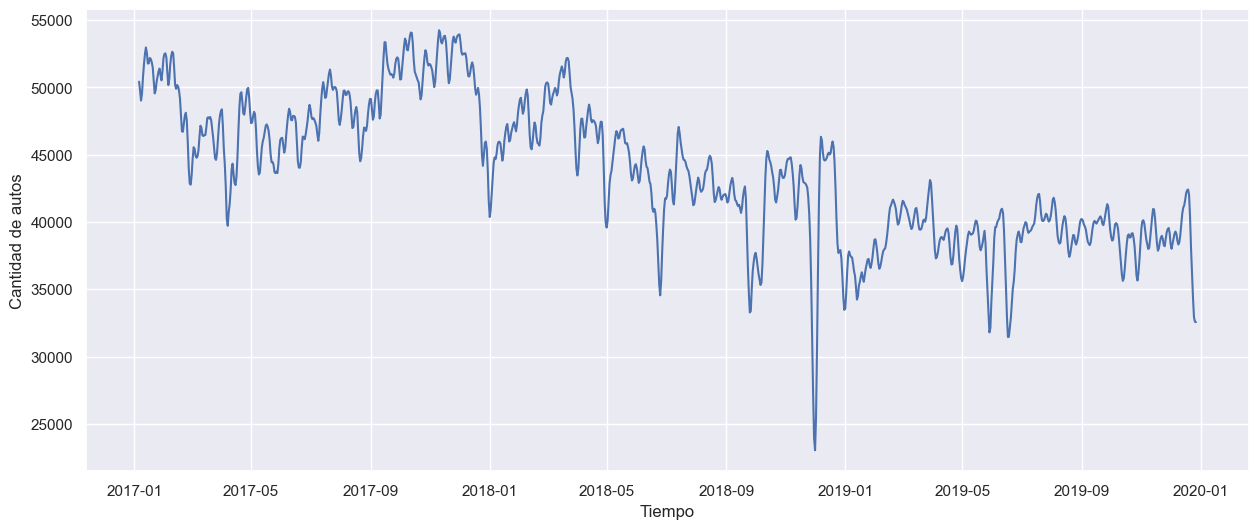

In [67]:
plt.figure(figsize = (15,6))
#plt.plot(diario.index, diario.cantidad_pasos, label = 'Diario')
plt.plot(diario_promedio.index, diario_promedio.cantidad_pasos, label = 'Diario Promedio')
# plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Semanal')
# plt.plot(semanal_promedio.index, semanal_promedio.cantidad_pasos, label = 'Semanal Promedio')
#plt.xlim(datetime.date(2018,1,1), datetime.date(2019,1,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

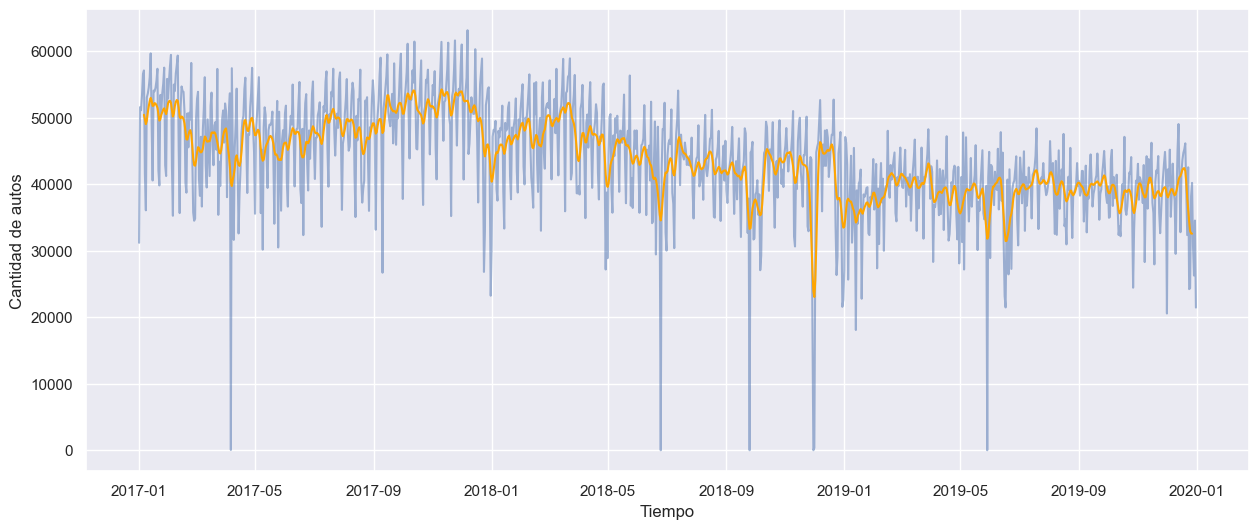

In [73]:
plt.figure(figsize = (15,6))
#plt.plot(diario.index, diario.cantidad_pasos, label = 'Diario')
plt.plot(daily.index, daily.cantidad_pasos, label = 'Diario Promedio', alpha = 0.5)
plt.plot(diario_promedio.index, diario_promedio.cantidad_pasos, label = 'Diario Promedio', color = 'orange')
# plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Semanal')
# plt.plot(semanal_promedio.index, semanal_promedio.cantidad_pasos, label = 'Semanal Promedio')
#plt.xlim(datetime.date(2018,1,1), datetime.date(2019,1,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

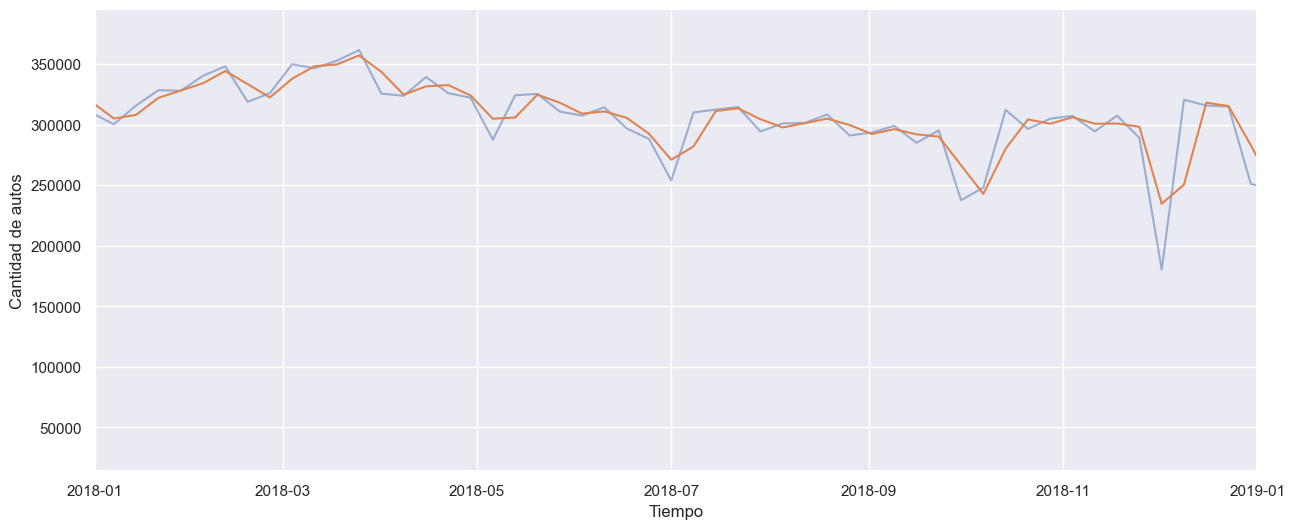

In [77]:
plt.figure(figsize = (15,6))
#plt.plot(diario.index, diario.cantidad_pasos, label = 'Diario')
plt.plot(weekly.index, weekly.cantidad_pasos, label = 'Semanal', alpha = 0.5)
plt.plot(semanal_promedio.index, semanal_promedio.cantidad_pasos, label = 'Semanal Promedio')
plt.xlim(datetime.date(2018,1,1), datetime.date(2019,1,1))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.show()

# 2. Forecasting con Prophet

In [87]:
from prophet import Prophet

In [88]:
diario

,hora_inicio,cantidad_pasos
ts_end_of_polling,,
2017-01-01,3033,31183
2017-01-02,3709,51568
2017-01-03,3602,51093
2017-01-04,3828,53332
2017-01-05,3790,56486
...,...,...
2019-12-27,1104,40182
2019-12-28,1104,30681
2019-12-29,1104,26259


In [96]:
df = daily.reset_index()
df.rename(columns = {'ts_end_of_polling':'ds', 'cantidad_pasos':'y'}, inplace = True)
df

,ds,hora_inicio,y
0,2017-01-01,3033,31183
1,2017-01-02,3709,51568
2,2017-01-03,3602,51093
3,2017-01-04,3828,53332
4,2017-01-05,3790,56486
...,...,...,...
1090,2019-12-27,1104,40182
1091,2019-12-28,1104,30681
1092,2019-12-29,1104,26259
1093,2019-12-30,1102,34523


In [98]:
#We fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.
m = Prophet()
m.fit(df)

21:16:33 - cmdstanpy - INFO - Chain [1] start processing
21:16:33 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1455,2020-12-26
1456,2020-12-27
1457,2020-12-28
1458,2020-12-29
1459,2020-12-30


In [103]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,48878.352322,31616.612787,46082.310321,48878.352322,48878.352322,-9837.804690,-9837.804690,-9837.804690,-6826.867315,-6826.867315,-6826.867315,-3010.937375,-3010.937375,-3010.937375,0.0,0.0,0.0,39040.547632
1,2017-01-02,48877.519478,37306.240808,51853.904981,48877.519478,48877.519478,-4247.869995,-4247.869995,-4247.869995,-1086.704346,-1086.704346,-1086.704346,-3161.165649,-3161.165649,-3161.165649,0.0,0.0,0.0,44629.649483
2,2017-01-03,48876.686635,38291.922937,52858.351634,48876.686635,48876.686635,-3237.701022,-3237.701022,-3237.701022,33.858796,33.858796,33.858796,-3271.559818,-3271.559818,-3271.559818,0.0,0.0,0.0,45638.985613
3,2017-01-04,48875.853791,40210.781714,54938.737587,48875.853791,48875.853791,-1409.476175,-1409.476175,-1409.476175,1931.626928,1931.626928,1931.626928,-3341.103103,-3341.103103,-3341.103103,0.0,0.0,0.0,47466.377616
4,2017-01-05,48875.020947,41559.710469,55644.340799,48875.020947,48875.020947,-295.682084,-295.682084,-295.682084,3073.829754,3073.829754,3073.829754,-3369.511838,-3369.511838,-3369.511838,0.0,0.0,0.0,48579.338864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2020-12-26,34513.067868,23573.692975,38372.842368,32615.745451,36517.121296,-3838.603643,-3838.603643,-3838.603643,-2421.766271,-2421.766271,-2421.766271,-1416.837372,-1416.837372,-1416.837372,0.0,0.0,0.0,30674.464225
1456,2020-12-27,34505.667424,18893.433602,33755.076396,32600.366376,36520.355642,-8573.610370,-8573.610370,-8573.610370,-6826.867315,-6826.867315,-6826.867315,-1746.743055,-1746.743055,-1746.743055,0.0,0.0,0.0,25932.057054
1457,2020-12-28,34498.266980,23791.675573,38554.395731,32581.586486,36523.589988,-3143.437221,-3143.437221,-3143.437221,-1086.704346,-1086.704346,-1086.704346,-2056.732875,-2056.732875,-2056.732875,0.0,0.0,0.0,31354.829759
1458,2020-12-29,34490.866536,24667.210045,40410.123575,32563.468546,36526.824334,-2308.253251,-2308.253251,-2308.253251,33.858796,33.858796,33.858796,-2342.112046,-2342.112046,-2342.112046,0.0,0.0,0.0,32182.613285


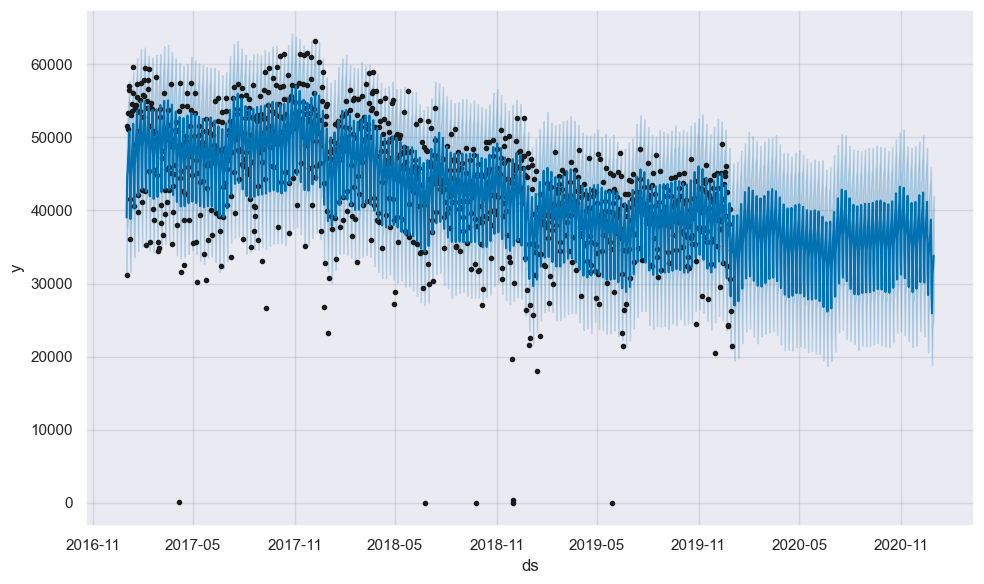

In [102]:
forecast = m.predict(future)
fig1 = m.plot(forecast)

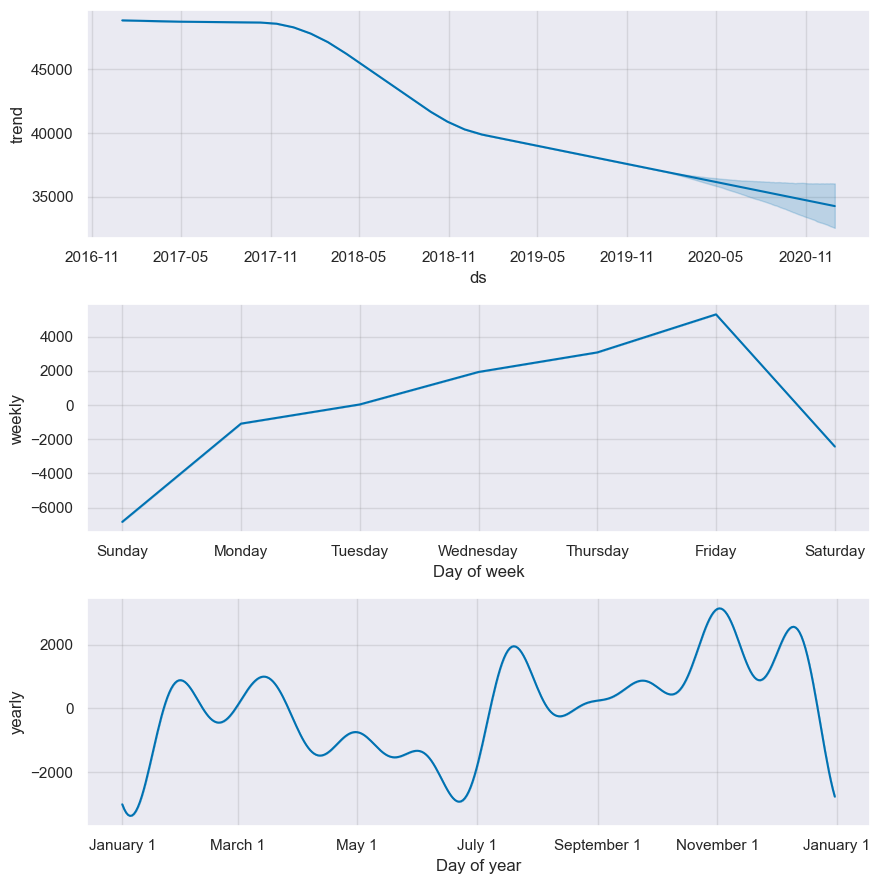

In [67]:
fig2 = m.plot_components(forecast)